# BioBuilder API Demo

In [1]:
import sys

sys.path.insert(0, '..')

import os
import requests

caravagna_model_filepath = '../biosimulator_processes/model_files/Caravagna2010.xml'
print(os.path.exists(caravagna_model_filepath))

tumor_control_biomodel_id = 'BIOMD0000000749'
requests.get('https://www.ebi.ac.uk/biomodels/BIOMD0000000749', headers={'accept': 'application/json'}).json()

True


{'name': 'Reppas2015 - tumor control via alternating immunostimulating and immunosuppressive phases',
 'description': 'The paper describes a model of tumor control via alternating immunostimulating and immunosuppressive phases. \r\nCreated by COPASI 4.25 (Build 207) \r\n\r\nThis model is described in the article: \r\nIn silico tumor control induced via alternating immunostimulating and immunosuppressive phases\r\nAI Reppas, JCL Alfonso, and H Hatzikirou\r\nVirulence 7:2, 174--186\r\n\r\nAbstract: \r\nDespite recent advances in the field of Oncoimmunology, the success potential of immunomodulatory therapies against cancer remains to be elucidated. One of the reasons is the lack of understanding on the complex interplay between tumor growth dynamics and the associated immune system responses. Toward this goal, we consider a mathematical model of vascularized tumor growth and the corresponding effector cell recruitment dynamics. Bifurcation analysis allows for the exploration of model’s d

#### **_Experiment 1_**:  Here we cross a boundary in the stack that is a biological simulation. We go from model configuration, to experiment. Thus, this tooling sits at that level: both experiment specification AND experiment execution. It's not just a way to specify an experiment, but it is also a way to run it, given the many knobs and buttons that you can use predefine and customize the way the actual model is being solved. Our users are seeking to be involved in an experiment as a "stack". We should make a bigger distinction between terms like "model".

In [2]:
from process_bigraph import pp
from biosimulator_processes.biosimulator_builder import BuildPrompter
from biosimulator_processes.data_model import TimeCourseProcess, TimeCourseModel

CobraProcess registered successfully.
CopasiProcess registered successfully.
SmoldynProcess registered successfully.
TelluriumProcess registered successfully.


In [3]:
# 1a. define a model for the process composition. In this case, just one model to be re-used as configuration for the processes we create:

tc_model = TimeCourseModel(model_source=tumor_control_biomodel_id)

pp(tc_model)

TimeCourseModel(model_source='BIOMD0000000749',
                model_id='model_from_BIOMD0000000749',
                model_name='model_from_BIOMD0000000749',
                model_language='sbml',
                model_changes=None,
                model_units=None)


In [4]:
# 1b. define a TimeCourse process instance using the above object as a parameter. The other parameter is method. See BasiCO documentation for more details on solvers

tc_process = TimeCourseProcess(model=tc_model, method='tauleap')

In [5]:
# >> The process model instance is viewable as a dataclass...

pp(tc_process)

TimeCourseProcess(model=TimeCourseModel(model_source='BIOMD0000000749',
                                        model_id='model_from_BIOMD0000000749',
                                        model_name='model_from_BIOMD0000000749',
                                        model_language='sbml',
                                        model_changes=None,
                                        model_units=None),
                  method='tauleap')


In [6]:
# >> ...or a dict:

pp(tc_process.to_dict())

{ 'method': 'tauleap',
  'model': { 'model_changes': None,
             'model_id': 'model_from_BIOMD0000000749',
             'model_language': 'sbml',
             'model_name': 'model_from_BIOMD0000000749',
             'model_source': 'BIOMD0000000749',
             'model_units': None}}


In [7]:
# 2. instantiate the prompter:

prompter = BuildPrompter()

In [8]:
# 3. add process(es) to the bigraph with the Time Course model instance we created above. For now, just one process will be added.

prompter.add_single_process(config=tc_process)

simple_a process successfully added to the bi-graph!
All nodes including the most recently added simple_a processes connected!
Done adding single simple_a (CopasiProcess) to the bigraph.


In [9]:
# 4. Inspect the builder instance within prompter:

pp(prompter.builder_instance)

Builder({ 'emitter': { '_type': 'step',
               'address': 'local:ram-emitter',
               'config': {'emit': {}},
               'inputs': {},
               'instance': <process_bigraph.composite.RAMEmitter object at 0x293f35420>,
               'outputs': {}},
  'simple_a': { '_type': 'process',
                'address': 'local:CopasiProcess',
                'config': { 'method': 'tauleap',
                            'model': { 'model_changes': { 'global_parameter_changes': None,
                                                          'reaction_changes': None,
                                                          'species_changes': None},
                                       'model_id': 'model_from_BIOMD0000000749',
                                       'model_language': 'sbml',
                                       'model_name': 'model_from_BIOMD0000000749',
                                       'model_source': 'BIOMD0000000749',
                           

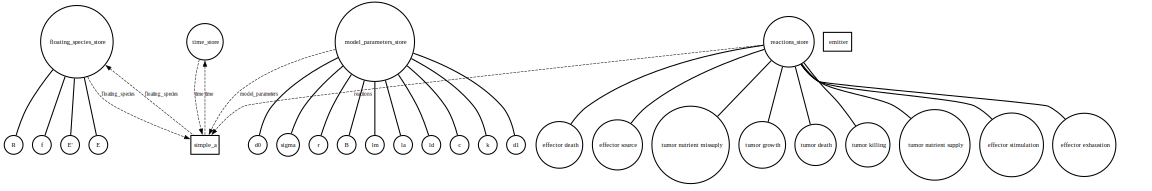

In [10]:
# 5. Visualize the fully-connected composition:

prompter.visualize_bigraph()

In [11]:
# 6. Generate a composite engine and use to execute the bigraph that we just created:

prompter.run()

Error while running the simulation: >ERROR 2024-03-15T12:56:15<
  CCopasiTask (5): No output file defined for report of task 'Time-Course'.>EXCEPTION 2024-03-15T12:56:15<
  CTrajectoryMethod (12): Internal step limit exceeded.
/Users/alex/Desktop/uchc_work/repos/biosimulator-processes/notebooks/../biosimulator_processes/processes/copasi_process.py:231: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Error while running the simulation: >ERROR 2024-03-15T12:56:15<
  CCopasiTask (5): No output file defined for report of task 'Time-Course'.>EXCEPTION 2024-03-15T12:56:15<
  CTrajectoryMethod (12): Internal step limit exceeded.


Generating composite...
Composite generated!
Running generated composite for an interval of 2
Composite successfully run. Request complete. Done.


In [12]:
# 6. Save the composite to a document:

prompter.builder_instance.write(filename='demo_tumor_control_composite')

File 'demo_tumor_control_composite' successfully written in 'out' directory.


#### **_Experiment 2_**: Load an SBML model from a specified model filepath and add Model changes to the composite before adding it to the bigraph. Here, we expect the user to be familiar enough with the model file they are passing to make individual species/parameter/reaction changes for specific species types. In the Caravagna model, for example, the species involved are T, E, I. Let's change the initial concentration for some of these as an example of model changes:

In [13]:
from biosimulator_processes.data_model import TimeCourseModelChanges, ModelChanges, ModelChange

In [13]:
# first make the timecourse model which is easily configured with objects related to model changes
adjusted_tc_model_from_file = TimeCourseModel